In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt

In [36]:
data = pd.read_csv('C:/Users/Almer/Desktop/Crop_recommendation.csv')

top_labels = list(data['label'].value_counts().nlargest(6).index)
n_crops = len(top_labels)
crop_to_index = {lab: i for i, lab in enumerate(top_labels)}
index_to_crop = {i: lab for lab, i in crop_to_index.items()}

n_min, n_max = data['N'].min(), data['N'].max()
p_min, p_max = data['P'].min(), data['P'].max()
k_min, k_max = data['K'].min(), data['K'].max()
temp_min, temp_max = data['temperature'].min(), data['temperature'].max()
hum_min, hum_max = data['humidity'].min(), data['humidity'].max()
rain_min, rain_max = data['rainfall'].min(), data['rainfall'].max()

n_univ = np.arange(np.floor(n_min), np.ceil(n_max)+1, 0.5)
p_univ = np.arange(np.floor(p_min), np.ceil(p_max)+1, 0.5)
k_univ = np.arange(np.floor(k_min), np.ceil(k_max)+1, 1.0)
temp_univ = np.arange(np.floor(temp_min), np.ceil(temp_max)+1, 0.5)
hum_univ = np.arange(np.floor(hum_min), np.ceil(hum_max)+1, 0.5)
rain_univ = np.arange(np.floor(rain_min), np.ceil(rain_max)+1, 1.0)
crop_univ = np.arange(-0.5, n_crops - 1 + 0.6, 0.1)

n = ctrl.Antecedent(n_univ, 'n')
p = ctrl.Antecedent(p_univ, 'p')
k = ctrl.Antecedent(k_univ, 'k')
temperature = ctrl.Antecedent(temp_univ, 'temperature')
humidity = ctrl.Antecedent(hum_univ, 'humidity')
rainfall = ctrl.Antecedent(rain_univ, 'rainfall')

crop_index = ctrl.Consequent(crop_univ, 'crop_index')

n_q25, n_q50, n_q75 = data['N'].quantile([0.25, 0.5, 0.75]).values
p_q25, p_q50, p_q75 = data['P'].quantile([0.25, 0.5, 0.75]).values
k_q25, k_q50, k_q75 = data['K'].quantile([0.25, 0.5, 0.75]).values
t_q25, t_q50, t_q75 = data['temperature'].quantile([0.25, 0.5, 0.75]).values
h_q25, h_q50, h_q75 = data['humidity'].quantile([0.25, 0.5, 0.75]).values
r_q25, r_q50, r_q75 = data['rainfall'].quantile([0.25, 0.5, 0.75]).values

n['low'] = fuzz.trimf(n.universe, [n_min, n_min, n_q50])
n['medium'] = fuzz.trimf(n.universe, [n_q25, n_q50, n_q75])
n['high'] = fuzz.trimf(n.universe, [n_q50, n_max, n_max])

p['low'] = fuzz.trimf(p.universe, [p_min, p_min, p_q50])
p['medium'] = fuzz.trimf(p.universe, [p_q25, p_q50, p_q75])
p['high'] = fuzz.trimf(p.universe, [p_q50, p_max, p_max])

k['low'] = fuzz.trimf(k.universe, [k_min, k_min, k_q50])
k['medium'] = fuzz.trimf(k.universe, [k_q25, k_q50, k_q75])
k['high'] = fuzz.trimf(k.universe, [k_q50, k_max, k_max])

temperature['low'] = fuzz.trimf(temperature.universe, [temp_min, temp_min, t_q50])
temperature['medium'] = fuzz.trimf(temperature.universe, [t_q25, t_q50, t_q75])
temperature['high'] = fuzz.trimf(temperature.universe, [t_q50, temp_max, temp_max])

humidity['low'] = fuzz.trimf(humidity.universe, [hum_min, hum_min, h_q50])
humidity['medium'] = fuzz.trimf(humidity.universe, [h_q25, h_q50, h_q75])
humidity['high'] = fuzz.trimf(humidity.universe, [h_q50, hum_max, hum_max])

rainfall['low'] = fuzz.trimf(rainfall.universe, [rain_min, rain_min, r_q50])
rainfall['medium'] = fuzz.trimf(rainfall.universe, [r_q25, r_q50, r_q75])
rainfall['high'] = fuzz.trimf(rainfall.universe, [r_q50, rain_max, rain_max])

for i in range(n_crops):
    left = i - 0.6
    center = i
    right = i + 0.6
    crop_index[str(i)] = fuzz.trimf(crop_index.universe, [left, center, right])

grouped = data[data['label'].isin(top_labels)].groupby('label').agg({
    'N': 'mean',
    'P': 'mean',
    'K': 'mean',
    'temperature': 'mean',
    'humidity': 'mean',
    'rainfall': 'mean'
}).loc[top_labels]

def term_from_value(val, q25, q50, q75):
    if val <= q25:
        return 'low'
    elif val <= q50:
        return 'medium'
    elif val <= q75:
        return 'high'
    else:
        return 'high'

rules = []
for lab in top_labels:
    v = grouped.loc[lab]
    n_term = term_from_value(v['N'], n_q25, n_q50, n_q75)
    p_term = term_from_value(v['P'], p_q25, p_q50, p_q75)
    k_term = term_from_value(v['K'], k_q25, k_q50, k_q75)
    t_term = term_from_value(v['temperature'], t_q25, t_q50, t_q75)
    h_term = term_from_value(v['humidity'], h_q25, h_q50, h_q75)
    r_term = term_from_value(v['rainfall'], r_q25, r_q50, r_q75)
    idx = crop_to_index[lab]
    rules.append(ctrl.Rule(n[n_term] & p[p_term] & k[k_term] & temperature[t_term] & humidity[h_term] & rainfall[r_term], crop_index[str(idx)]))

highest_n_crop = grouped['N'].idxmax(); highest_n_idx = crop_to_index[highest_n_crop]
lowest_n_crop = grouped['N'].idxmin(); lowest_n_idx = crop_to_index[lowest_n_crop]

highest_p_crop = grouped['P'].idxmax(); highest_p_idx = crop_to_index[highest_p_crop]
lowest_p_crop = grouped['P'].idxmin(); lowest_p_idx = crop_to_index[lowest_p_crop]

highest_k_crop = grouped['K'].idxmax(); highest_k_idx = crop_to_index[highest_k_crop]
lowest_k_crop = grouped['K'].idxmin(); lowest_k_idx = crop_to_index[lowest_k_crop]

highest_rain_crop = grouped['rainfall'].idxmax(); highest_rain_idx = crop_to_index[highest_rain_crop]
lowest_rain_crop = grouped['rainfall'].idxmin(); lowest_rain_idx = crop_to_index[lowest_rain_crop]

highest_hum_crop = grouped['humidity'].idxmax(); highest_hum_idx = crop_to_index[highest_hum_crop]
lowest_hum_crop = grouped['humidity'].idxmin(); lowest_hum_idx = crop_to_index[lowest_hum_crop]

highest_temp_crop = grouped['temperature'].idxmax(); highest_temp_idx = crop_to_index[highest_temp_crop]
lowest_temp_crop = grouped['temperature'].idxmin(); lowest_temp_idx = crop_to_index[lowest_temp_crop]


rules.append(ctrl.Rule(n['high'], crop_index[str(highest_n_idx)]))
rules.append(ctrl.Rule(n['low'], crop_index[str(lowest_n_idx)]))

rules.append(ctrl.Rule(p['high'], crop_index[str(highest_p_idx)]))
rules.append(ctrl.Rule(p['low'], crop_index[str(lowest_p_idx)]))

rules.append(ctrl.Rule(k['high'], crop_index[str(highest_k_idx)]))
rules.append(ctrl.Rule(k['low'], crop_index[str(lowest_k_idx)]))

rules.append(ctrl.Rule(rainfall['high'], crop_index[str(highest_rain_idx)]))
rules.append(ctrl.Rule(rainfall['low'], crop_index[str(lowest_rain_idx)]))

rules.append(ctrl.Rule(humidity['high'], crop_index[str(highest_hum_idx)]))
rules.append(ctrl.Rule(humidity['low'], crop_index[str(lowest_hum_idx)]))

rules.append(ctrl.Rule(temperature['high'], crop_index[str(highest_temp_idx)]))
rules.append(ctrl.Rule(temperature['low'], crop_index[str(lowest_temp_idx)]))

control_system = ctrl.ControlSystem(rules)
sim = ctrl.ControlSystemSimulation(control_system)

test_row = data.iloc[352]
sim.input['n'] = float(test_row['N'])
sim.input['p'] = float(test_row['P'])
sim.input['k'] = float(test_row['K'])
sim.input['temperature'] = float(test_row['temperature'])
sim.input['humidity'] = float(test_row['humidity'])
sim.input['rainfall'] = float(test_row['rainfall'])

sim.compute()

out_val = sim.output['crop_index']
out_idx = int(round(out_val))
out_idx = max(0, min(out_idx, n_crops-1))
recommended_crop = index_to_crop[out_idx]

print(f"Top-6 crops (index mapping):")
for crop_name,idx in crop_to_index.items():
    print(f"  {idx}: {crop_name}")
print()
print(f"Test input: temperature={test_row['temperature']}, humidity={test_row['humidity']}, rainfall={test_row['rainfall']}, label={test_row['label']}")
print(f"Defuzzified crop_index = {out_val:.3f} -> recommended: {recommended_crop} (index {out_idx})")


Top-6 crops (index mapping):
  0: rice
  1: maize
  2: chickpea
  3: kidneybeans
  4: pigeonpeas
  5: mothbeans

Test input: temperature=16.78791503, humidity=24.96881755, rainfall=75.45328039, label=kidneybeans
Defuzzified crop_index = 2.466 -> recommended: chickpea (index 2)


C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


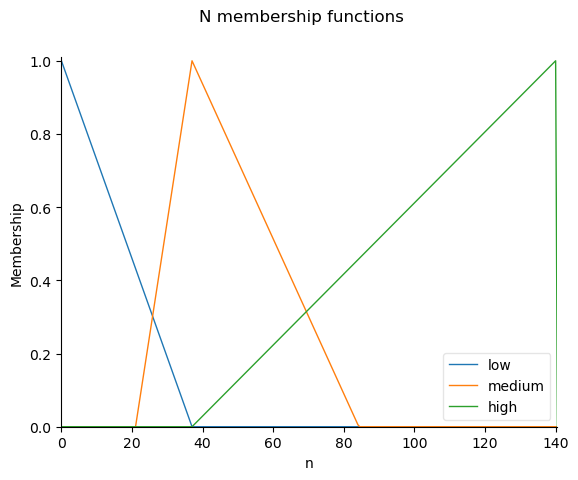

In [37]:
n.view()
plt.suptitle('N membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


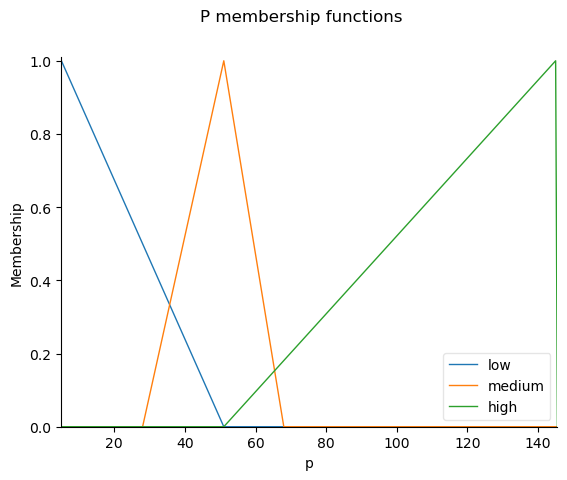

In [38]:
p.view()
plt.suptitle('P membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


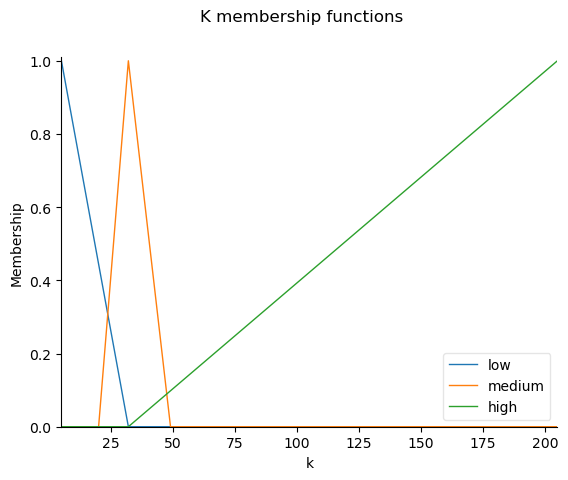

In [39]:
k.view()
plt.suptitle('K membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


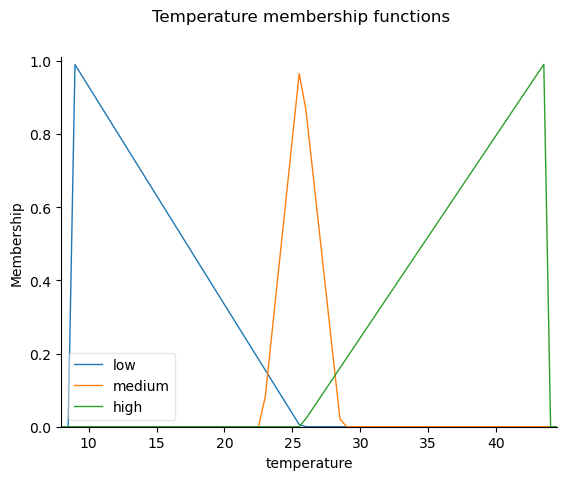

In [40]:
temperature.view()
plt.suptitle('Temperature membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


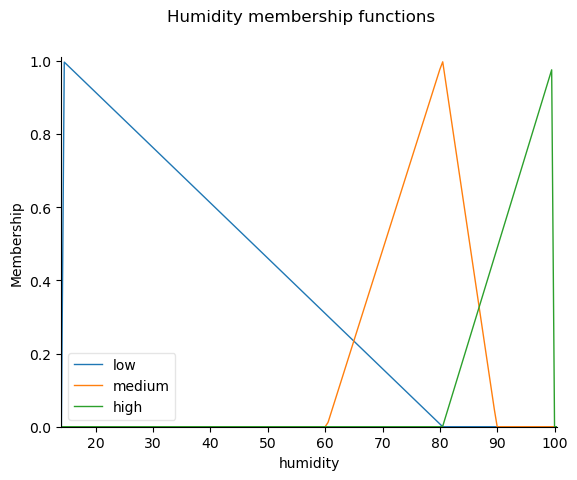

In [41]:
humidity.view()
plt.suptitle('Humidity membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


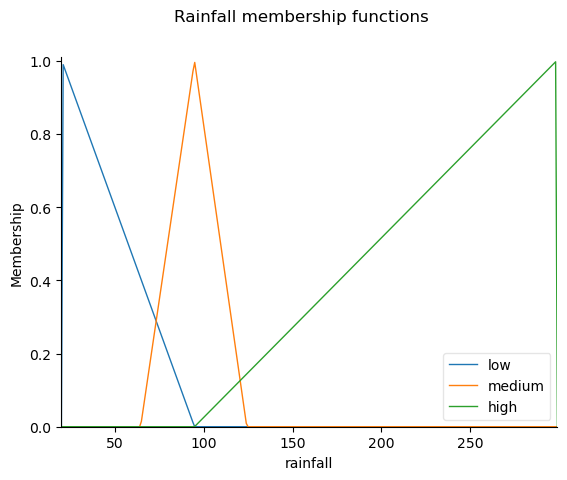

In [42]:
rainfall.view()
plt.suptitle('Rainfall membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


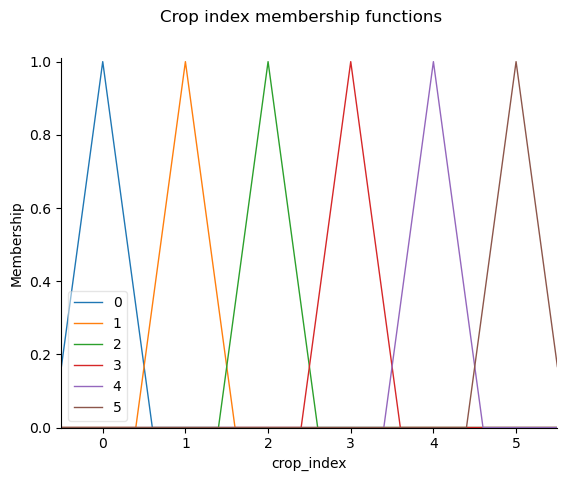

In [43]:
crop_index.view()
plt.suptitle('Crop index membership functions')
plt.show()

C:\Users\Almer\anaconda3\Lib\site-packages\skfuzzy\control\fuzzyvariable.py:125: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


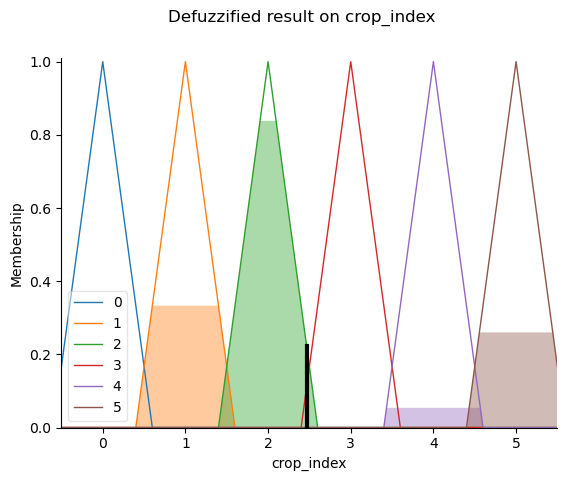

In [44]:
crop_index.view(sim=sim)
plt.suptitle('Defuzzified result on crop_index')
plt.show()